In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
path_high_pop = "input/spotify-music-dataset/high_popularity_spotify_data.csv"
path_low_pop = "input/spotify-music-dataset/low_popularity_spotify_data.csv"

In [3]:
df_high = pd.read_csv(path_high_pop)
df_low = pd.read_csv(path_low_pop)
df2 = pd.read_csv("input/-spotify-tracks-dataset/dataset.csv")

In [4]:
df = pd.concat([df_high, df_low], ignore_index=True)

print(f"Dimensões do DataFrame: {df.shape[0]} linhas, {df.shape[1]} colunas.")
print("\nColunas disponíveis:", df.columns.tolist())


Dimensões do DataFrame: 4831 linhas, 29 colunas.

Colunas disponíveis: ['time_signature', 'track_popularity', 'speechiness', 'danceability', 'playlist_name', 'track_artist', 'duration_ms', 'energy', 'playlist_genre', 'playlist_subgenre', 'track_href', 'track_name', 'mode', 'uri', 'type', 'track_album_release_date', 'analysis_url', 'id', 'instrumentalness', 'track_album_id', 'playlist_id', 'track_id', 'valence', 'key', 'tempo', 'loudness', 'acousticness', 'liveness', 'track_album_name']


In [ ]:
print(df.shape[0]) # df se refere ao dataset spotify-music-dataset combinado baixa e alta popularidade
print(df2.shape[0]) # df2 se refere ao dataset spotify-tracks-dataset
print(df.columns)
print(df2.columns)

4831
114000
Index(['time_signature', 'track_popularity', 'speechiness', 'danceability',
       'playlist_name', 'track_artist', 'duration_ms', 'energy',
       'playlist_genre', 'playlist_subgenre', 'track_href', 'track_name',
       'mode', 'uri', 'type', 'track_album_release_date', 'analysis_url', 'id',
       'instrumentalness', 'track_album_id', 'playlist_id', 'track_id',
       'valence', 'key', 'tempo', 'loudness', 'acousticness', 'liveness',
       'track_album_name'],
      dtype='object')
Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


In [6]:
# renomeando colunas em df para consistência
df.rename(columns={
    'track_artist': 'artists',
    'track_album_name': 'album_name',
    'track_popularity': 'popularity',
    'playlist_genre': 'track_genre'
}, inplace=True)

# removendo a coluna 'id' que é redundante com 'track_id'
df.drop(columns=['id'], inplace=True)

# Removendo a coluna 'Unnamed: 0' de df2
df2.drop(columns=['Unnamed: 0'], inplace=True)

print("Colunas de 'df' após a preparação:")
print(df.columns.tolist())

Colunas de 'df' após a preparação:
['time_signature', 'popularity', 'speechiness', 'danceability', 'playlist_name', 'artists', 'duration_ms', 'energy', 'track_genre', 'playlist_subgenre', 'track_href', 'track_name', 'mode', 'uri', 'type', 'track_album_release_date', 'analysis_url', 'instrumentalness', 'track_album_id', 'playlist_id', 'track_id', 'valence', 'key', 'tempo', 'loudness', 'acousticness', 'liveness', 'album_name']


In [7]:
colunas_df = set(df.columns)
colunas_df2 = set(df2.columns)

# encontrar colunas que estão em ambos os sets
colunas_em_comum = list(colunas_df.intersection(colunas_df2))

print(f"Encontradas {len(colunas_em_comum)} colunas em comum.")
print("Elas são:", colunas_em_comum)

Encontradas 19 colunas em comum.
Elas são: ['track_genre', 'tempo', 'energy', 'loudness', 'acousticness', 'danceability', 'track_id', 'artists', 'time_signature', 'liveness', 'popularity', 'duration_ms', 'album_name', 'valence', 'track_name', 'speechiness', 'key', 'mode', 'instrumentalness']


In [8]:
df_filtrado = df[colunas_em_comum]
df2_filtrado = df2[colunas_em_comum]

In [ ]:
# une os dois dataframes, agora que eles têm as mesmas colunas
df_completo = pd.concat([df_filtrado, df2_filtrado], ignore_index=True)
df_completo.drop_duplicates(subset=['track_id'], keep='first', inplace=True)

In [10]:
print(f"\ndim: {df_completo.shape}")
print(f"\n colunas: {df_completo.columns}")


dim: (93574, 19)

 colunas: Index(['track_genre', 'tempo', 'energy', 'loudness', 'acousticness',
       'danceability', 'track_id', 'artists', 'time_signature', 'liveness',
       'popularity', 'duration_ms', 'album_name', 'valence', 'track_name',
       'speechiness', 'key', 'mode', 'instrumentalness'],
      dtype='object')


In [11]:
def map_genres_to_broad_categories(df: pd.DataFrame) -> pd.DataFrame:
    """
    Mapeia os gêneros musicais detalhados da coluna 'track_genre' para categorias amplas,
    retornando um novo DataFrame com a coluna de gênero modificada.

    Args:
        df (pd.DataFrame): O DataFrame de entrada contendo a coluna 'track_genre'.

    Returns:
        pd.DataFrame: Uma cópia do DataFrame com a coluna 'track_genre' atualizada
                      para categorias de gênero amplas. Gêneros não mapeados
                      são agrupados na categoria 'other'.
    """
    if 'track_genre' not in df.columns:
        raise ValueError("O DataFrame precisa conter a coluna 'track_genre'.")

    df_mapped = df.copy()

    category_map = {
        'electronic': ['breakbeat', 'chicago-house', 'club', 'dance', 'dancehall', 'deep-house',
                       'detroit-techno', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro',
                       'electronic', 'garage', 'hardstyle', 'house', 'idm', 'minimal-techno',
                       'progressive-house', 'tech-house', 'techno', 'trance', 'trip-hop'],
        'pop': ['pop', 'power-pop', 'indie-pop', 'synth-pop'],
        'hip-hop': ['hip-hop'],
        'rock': ['alt-rock', 'alternative', 'emo', 'goth', 'grunge', 'hard-rock',
                 'psych-rock', 'rock', 'rock-n-roll', 'rockabilly', 'j-rock', 'industrial',
                 'indie'],
        'metal': ['metal', 'black-metal', 'death-metal', 'heavy-metal', 'metalcore', 'grindcore'],
        'punk': ['punk', 'punk-rock', 'hardcore', 'ska'],
        'latin': ['latin', 'latino', 'reggaeton', 'salsa', 'spanish'],
        'brazilian': ['brazil', 'forro', 'mpb', 'pagode', 'samba', 'sertanejo',
                      'brazilian'],
        'world': ['world-music', 'malay', 'turkish', 'iranian', 'british', 'french', 'german', 
                  'swedish', 'indian', 'afrobeat', 'afrobeats', 'arabic', 'world', 'cantopop', 'mandopop',
                  'korean'], 
        'k-pop': ['k-pop'],
        'j-pop': ['j-pop', 'j-idol',
                  'j-dance'], 
        'r-n-b': ['r-n-b', 'r&b', 'soul', 'groove'],
        'jazz': ['jazz'],
        'funk': ['funk'],
        'blues': ['blues'],
        'reggae': ['reggae'],
        'country': ['country', 'bluegrass', 'honky-tonk'],
        'disco': ['disco', 'party'],
        'classical': ['classical', 'opera', 'piano'],
        'folk': ['folk', 'acoustic'],
        'singer-songwriter': ['singer-songwriter', 'songwriter'],
        'soundtrack': ['soundtrack', 'pop-film', 'anime', 'disney',
                       'show-tunes'],
        'instrumental': ['guitar'],
        'ambient': ['ambient', 'chill', 'new-age'],
        'gaming': ['gaming'],
        'lofi': ['lofi'],
        'children': ['children', 'kids'],
        'comedy': ['comedy'],
        'gospel': ['gospel'],
        'wellness': ['romance', 'sad', 'sleep', 'study', 'happy', 'wellness'],
        'tango': ['tango'],
        'soca': ['soca']
    }

    genre_mapping = {subgenre: category
                     for category, subgenres in category_map.items()
                     for subgenre in subgenres}

    df_mapped['track_genre'] = df_mapped['track_genre'].map(genre_mapping).fillna('other')

    return df_mapped

In [12]:
df_completo = map_genres_to_broad_categories(df_completo)

In [13]:
print(df_completo['track_genre'].value_counts())
print(df_completo.dtypes)

track_genre
electronic           18194
world                11301
rock                  8906
brazilian             5156
metal                 4847
wellness              4533
soundtrack            3696
latin                 3506
ambient               3237
pop                   3159
country               2926
classical             2613
j-pop                 2508
punk                  2419
children              1960
folk                  1894
disco                 1740
r-n-b                 1644
hip-hop               1177
blues                 1002
tango                  999
comedy                 990
k-pop                  916
instrumental           884
funk                   781
gospel                 706
jazz                   667
singer-songwriter      520
lofi                   299
reggae                 273
gaming                 107
soca                    14
Name: count, dtype: int64
track_genre          object
tempo               float64
energy              float64
loudness      

In [14]:
print(f"Tamanho antes do dropna: {df_completo.shape}")
df_sem_na = df_completo.dropna()
print(f"Tamanho depois do dropna: {df_sem_na.shape}")

Tamanho antes do dropna: (93574, 19)
Tamanho depois do dropna: (93571, 19)


In [ ]:
df_processed = df_sem_na

In [ ]:
print("dando olhada na cardinalidade")
# fizemos isso para ver se seria viável utilizar o one-hot-encoding
print("Valores únicos e suas contagens para a coluna 'key':")
key_counts = df_processed['key'].value_counts()
print(key_counts)
print(f"\n Qt de ocorrencias'key': {df_processed['key'].nunique()}")
print("-" * 50)

print("Valores únicos e suas contagens para a coluna 'time_signature':")
time_signature_counts = df_processed['time_signature'].value_counts()
print(time_signature_counts)
print(f"\n Qt de ocorrencias em 'time_signature': {df_processed['time_signature'].nunique()}")
print("-" * 50)

print("Valores únicos e suas contagens para a coluna 'track_genre':")
playlist_genre_counts = df_processed['track_genre'].value_counts()
print(playlist_genre_counts)
print(f"\nQt de ocorrencias em 'playlist_genre': {df_processed['track_genre'].nunique()}")
print("-" * 50)

dando olhada na cardinalidade
Valores únicos e suas contagens para a coluna 'key':
key
7.0     10939
0.0     10762
2.0      9693
9.0      9335
1.0      9038
5.0      7630
11.0     7445
4.0      7412
6.0      6446
10.0     6145
8.0      5823
3.0      2905
Name: count, dtype: int64

 Qt de ocorrencias'key': 12
--------------------------------------------------
Valores únicos e suas contagens para a coluna 'time_signature':
time_signature
4.0    82929
3.0     7887
5.0     1719
1.0      876
0.0      162
Name: count, dtype: int64

 Qt de ocorrencias em 'time_signature': 5
--------------------------------------------------
Valores únicos e suas contagens para a coluna 'track_genre':
track_genre
electronic           18194
world                11301
rock                  8906
brazilian             5156
metal                 4847
wellness              4533
soundtrack            3696
latin                 3506
ambient               3237
pop                   3159
country               2926
class

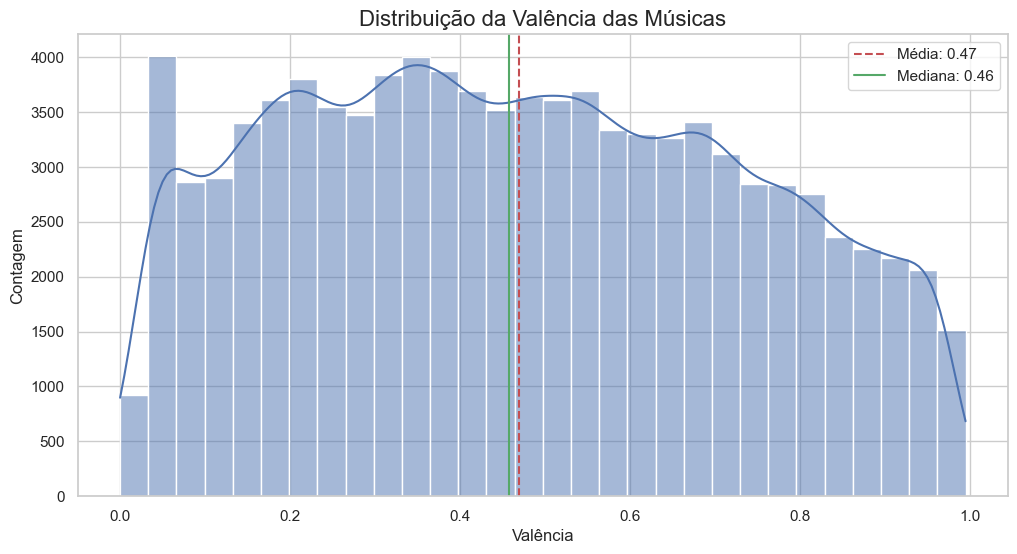

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df_processed['valence'], kde=True, bins=30)
plt.axvline(df_processed['valence'].mean(), color='r', linestyle='--', label=f'Média: {df_processed["valence"].mean():.2f}')

plt.axvline(df_processed['valence'].median(), color='g', linestyle='-', label=f'Mediana: {df_processed["valence"].median():.2f}')

plt.title('Distribuição da Valência das Músicas', fontsize=16)
plt.xlabel('Valência', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.legend()
plt.show()
# gráfico gerado para verificar a questão "Distribuição muito assimétrica (skewed) da variável alvo"
# estamos vendo se a variável alvo está sendo bem distribuída

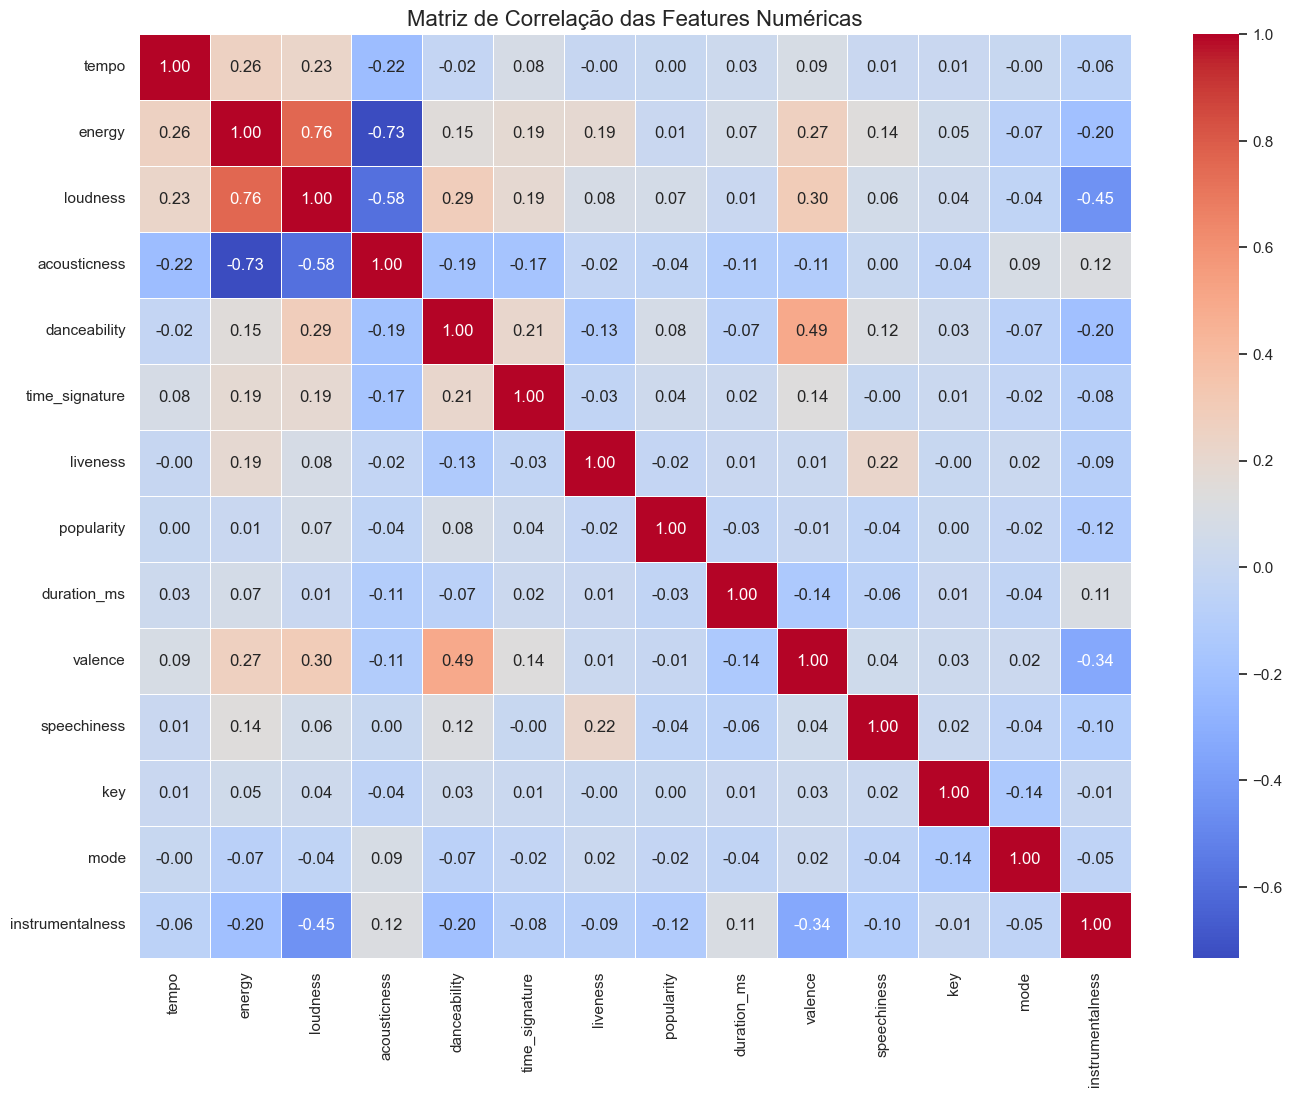


Correlação das features com 'valence':
valence             1.000000
danceability        0.493795
loudness            0.299764
energy              0.266262
time_signature      0.135540
tempo               0.090960
speechiness         0.038560
key                 0.027271
mode                0.020546
liveness            0.013516
popularity         -0.007511
acousticness       -0.114214
duration_ms        -0.143349
instrumentalness   -0.335404
Name: valence, dtype: float64
Índice de 'Previsibilidade' (Soma das Correlações Absolutas):
loudness            3.090246
energy              3.083501
acousticness        2.433687
danceability        2.049975
valence             1.986693
instrumentalness    1.923380
time_signature      1.191773
tempo               1.007091
speechiness         0.851827
liveness            0.832760
duration_ms         0.699576
mode                0.626059
popularity          0.480314
key                 0.397664
dtype: float64


In [ ]:
# seleciona apenas as colunas numéricas para a correlação
numeric_cols = df_processed.select_dtypes(include=np.number).columns

# calcula a matriz de correlação
correlation_matrix = df_processed[numeric_cols].corr()

# plota o heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Features Numéricas', fontsize=16)
plt.show()

# veja especificamente a correlação com a 'valence'
print("\nCorrelação das features com 'valence':")
print(correlation_matrix['valence'].sort_values(ascending=False))
predictability_score = correlation_matrix.abs().sum() - 1

# ordena para ver as mais "previsíveis" no topo
print("Índice de 'Previsibilidade' (Soma das Correlações Absolutas):")
print(predictability_score.sort_values(ascending=False))

In [20]:
categorical_cols = ['track_genre', 'key', 'time_signature']
for col in categorical_cols:
    df_processed[col] = df_processed[col].astype('object')

df_processed = pd.get_dummies(df_processed, columns=categorical_cols, prefix=categorical_cols)

print("DataFrame após o One-Hot Encoding refinado:")
display(df_processed.head())


DataFrame após o One-Hot Encoding refinado:


,tempo,energy,loudness,acousticness,danceability,track_id,artists,liveness,popularity,duration_ms,...,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,132.310,0.746,-3.785,0.0648,0.636,5e6x5YRnMJIKvYpZxLqdpH,Creedence Clearwater Revival,0.1730,23,138053.0,...,False,False,False,False,False,False,False,False,True,False
1,129.981,0.835,-6.219,0.1710,0.572,5FqYA8KfiwsQvyBI4IamnY,Van Halen,0.0702,53,241600.0,...,False,False,False,False,False,False,False,False,True,False
2,111.457,0.804,-7.299,0.3270,0.591,5LNiqEqpDc8TuqPy79kDBu,Stevie Nicks,0.0818,55,329413.0,...,False,False,False,False,False,False,False,False,True,False
3,76.474,0.104,-17.042,0.9130,0.443,78MI7mu1LV1k4IA2HzKmHe,"Ella Fitzgerald, Louis Armstrong",0.1910,64,185160.0,...,False,False,False,False,False,False,False,False,True,False
4,80.487,0.472,-9.691,0.7850,0.685,6MN6yRVriszuyAVlyF8ndB,Galt MacDermot,0.2240,62,205720.0,...,False,False,True,False,False,False,False,False,True,False


In [ ]:
print("Verificando os tipos de dados do DataFrame 'df_processed':")
print(df_processed.dtypes)

print("-" * 50)

# filtra e mostra apenas as colunas que NÃO são numéricas
colunas_de_texto = df_processed.select_dtypes(include=['object']).columns.tolist()


print("Colunas de texto encontradas a serem removidas:")
print(colunas_de_texto)

In [ ]:
print("Removendo colunas de texto/ID que não são features: ")
cols_to_drop_final = ['track_id', 'artists', 'album_name', 'track_name'] 

# usamos .select_dtypes para garantir que só fiquem colunas numéricas (int, float, bool), isso remove automaticamente qualquer coluna de texto que tenha sobrado
df_model = df_processed.select_dtypes(include=np.number)

Removendo colunas de texto/ID que não são features...


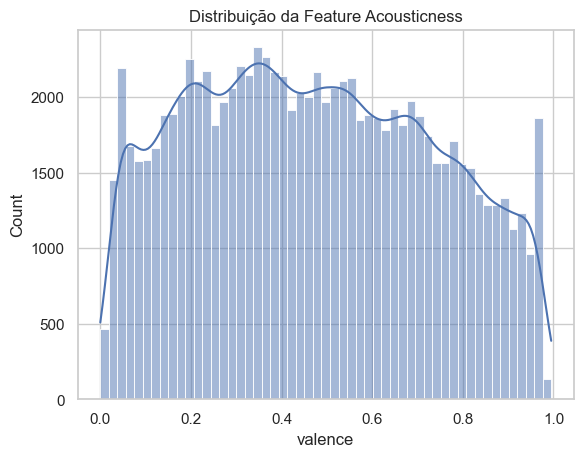

In [23]:
sns.histplot(data=df_model, x='valence', kde=True)
plt.title('Distribuição da Feature Acousticness')
plt.show()

In [ ]:
# calcula a mediana da coluna 'valence'
median_valence = df_model['valence'].median()

# imprime o threshold que será usado 
print(f"O threshold (ponto de corte) definido pela mediana é: {median_valence:.4f}")

# cria a nova coluna de classe binária 'valence_class'
df_model['valence_class'] = (df_model['valence'] > median_valence).astype(int)

# verifica o balanceamento das classes (deve ser quase 50/50)
print("\nBalanceamento das novas classes:")
print(df_model['valence_class'].value_counts(normalize=True))

O threshold (ponto de corte) definido pela mediana é: 0.4580

Balanceamento das novas classes:
valence_class
0    0.500075
1    0.499925
Name: proportion, dtype: float64


In [25]:
df_model = df_model.copy()
df_model.describe()

,tempo,energy,loudness,acousticness,danceability,liveness,popularity,duration_ms,valence,speechiness,mode,instrumentalness,valence_class
count,93573.000000,93573.000000,93573.000000,93573.000000,93573.000000,93573.000000,93574.000000,9.357300e+04,93573.000000,93573.000000,93573.000000,93573.000000,93574.000000
mean,121.892309,0.631595,-8.553366,0.330028,0.564663,0.214921,33.873074,2.280024e+05,0.469653,0.088103,0.633890,0.175904,0.499925
std,30.078351,0.256774,5.344388,0.338178,0.177816,0.192739,20.759244,1.120620e+05,0.262803,0.112906,0.481743,0.326175,0.500003
min,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.024000,0.455000,-10.349000,0.018400,0.452000,0.098100,20.000000,1.720350e+05,0.249000,0.036100,0.000000,0.000000,0.000000
50%,121.991000,0.673000,-7.200000,0.191000,0.579000,0.131000,34.000000,2.122400e+05,0.458000,0.049200,1.000000,0.000061,0.000000
75%,140.051000,0.849000,-5.126000,0.626000,0.696000,0.275000,49.000000,2.627070e+05,0.683000,0.087100,1.000000,0.104000,1.000000
max,243.372000,1.000000,4.532000,0.996000,0.985000,1.000000,100.000000,5.237295e+06,0.995000,0.965000,1.000000,1.000000,1.000000


In [26]:
print(df_model.isnull().sum())
print(df_model.shape)
df_model = df_model.dropna()
print(df_model.shape)

tempo               1
energy              1
loudness            1
acousticness        1
danceability        1
liveness            1
popularity          0
duration_ms         1
valence             1
speechiness         1
mode                1
instrumentalness    1
valence_class       0
dtype: int64
(93574, 13)
(93573, 13)


In [ ]:
# a nossa variável alvo 'y' é a coluna que acabamos de criar
y = df_model['valence_class']

# as nossas features 'X' são todas as outras colunas, exceto a 'valence' original, e a nova 'valence_class' que é o nosso alvo.
X = df_model.drop(columns=['valence', 'valence_class'])

print(f"Formato de X (features): {X.shape}")
print(f"Formato de y (alvo): {y.shape}")

Formato de X (features): (93573, 11)
Formato de y (alvo): (93573,)


In [ ]:

# usamos stratify=y para garantir que a proporção 50/50 das classes seja mantida nos dois conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treino: 74858 amostras
Tamanho do conjunto de teste: 18715 amostras


In [ ]:
scaler = StandardScaler()

# aprende a escala com os dados de treino e os transforma
X_train_scaled = scaler.fit_transform(X_train)

# apenas transforma os dados de teste com a escala aprendida no treino
X_test_scaled = scaler.transform(X_test)

print("Dados de treino e teste escalonados com sucesso!")

Dados de treino e teste escalonados com sucesso!


### TREINAMENTO

In [ ]:
# lista para armazenar os resultados resumidos de cada modelo
results_list = []
# dicionário para guardar os melhores modelos e suas previsões para a análise detalhada
analysis_data = {}

In [33]:
print("\n--- Treinando Regressão Logística ---")
start_time = time.time()
model_lr = LogisticRegression(max_iter=1000, random_state=42)
param_grid_lr = {'C': [0.1, 1.0, 10.0]}
grid_lr = GridSearchCV(model_lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
results_list.append({'Modelo': 'Regressão Logística', 'Acurácia': accuracy_lr, 'Melhores Parâmetros': grid_lr.best_params_, 'Tempo (s)': time.time() - start_time})
analysis_data['Regressão Logística'] = {'model': best_lr, 'y_pred': y_pred_lr}
print(f"Finalizado em {time.time() - start_time:.2f}s. Acurácia: {accuracy_lr:.4f}")


--- Treinando Regressão Logística ---
Finalizado em 5.88s. Acurácia: 0.7234


In [ ]:
print("\n--- Treinando Random Forest Classifier ---")
start_time = time.time()
model_rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_leaf': [2, 4]}
grid_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
results_list.append({'Modelo': 'Random Forest', 'Acurácia': accuracy_rf, 'Melhores Parâmetros': grid_rf.best_params_, 'Tempo (s)': time.time() - start_time})
analysis_data['Random Forest'] = {'model': best_rf, 'y_pred': y_pred_rf}
print(f"Finalizado em {time.time() - start_time:.2f}s. Acurácia: {accuracy_rf:.4f}")


--- Treinando Random Forest Classifier ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finalizado em 199.87s. Acurácia: 0.7876


In [35]:
print("\n--- Treinando Gradient Boosting Classifier ---")
start_time = time.time()
model_gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
grid_gb = GridSearchCV(model_gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_gb.fit(X_train_scaled, y_train)
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
results_list.append({'Modelo': 'Gradient Boosting', 'Acurácia': accuracy_gb, 'Melhores Parâmetros': grid_gb.best_params_, 'Tempo (s)': time.time() - start_time})
analysis_data['Gradient Boosting'] = {'model': best_gb, 'y_pred': y_pred_gb}
print(f"Finalizado em {time.time() - start_time:.2f}s. Acurácia: {accuracy_gb:.4f}")


--- Treinando Gradient Boosting Classifier ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finalizado em 329.29s. Acurácia: 0.7761


In [36]:
df_results = pd.DataFrame(results_list).sort_values(by='Acurácia', ascending=False).reset_index(drop=True)
display(df_results)


,Modelo,Acurácia,Melhores Parâmetros,Tempo (s)
0,Random Forest,0.787604,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es...",199.870212
1,Gradient Boosting,0.776115,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",329.286023
2,Regressão Logística,0.723377,{'C': 0.1},5.883579



--- ANÁLISE DETALHADA DO MODELO CAMPEÃO: Random Forest ---

>>> Relatório de Classificação:

                 precision    recall  f1-score   support

Humor Baixo (0)       0.80      0.77      0.78      9359
 Humor Alto (1)       0.78      0.81      0.79      9356

       accuracy                           0.79     18715
      macro avg       0.79      0.79      0.79     18715
   weighted avg       0.79      0.79      0.79     18715


>>> Matriz de Confusão:



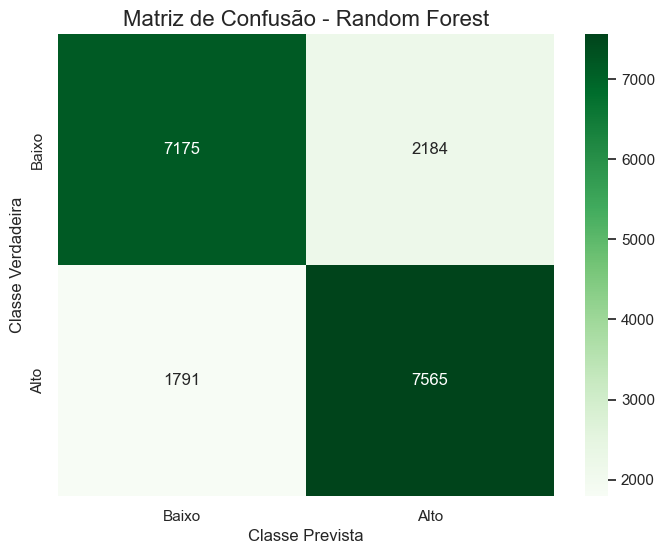


>>> Importância das Features:

As 15 features mais importantes para o modelo:


,Feature,Importance
4,danceability,0.209967
1,energy,0.125084
10,instrumentalness,0.102092
7,duration_ms,0.092734
3,acousticness,0.089386
2,loudness,0.081317
8,speechiness,0.080259
0,tempo,0.073311
5,liveness,0.071807
6,popularity,0.064742


C:\Users\victo\AppData\Local\Temp\ipykernel_10756\524244264.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='rocket')


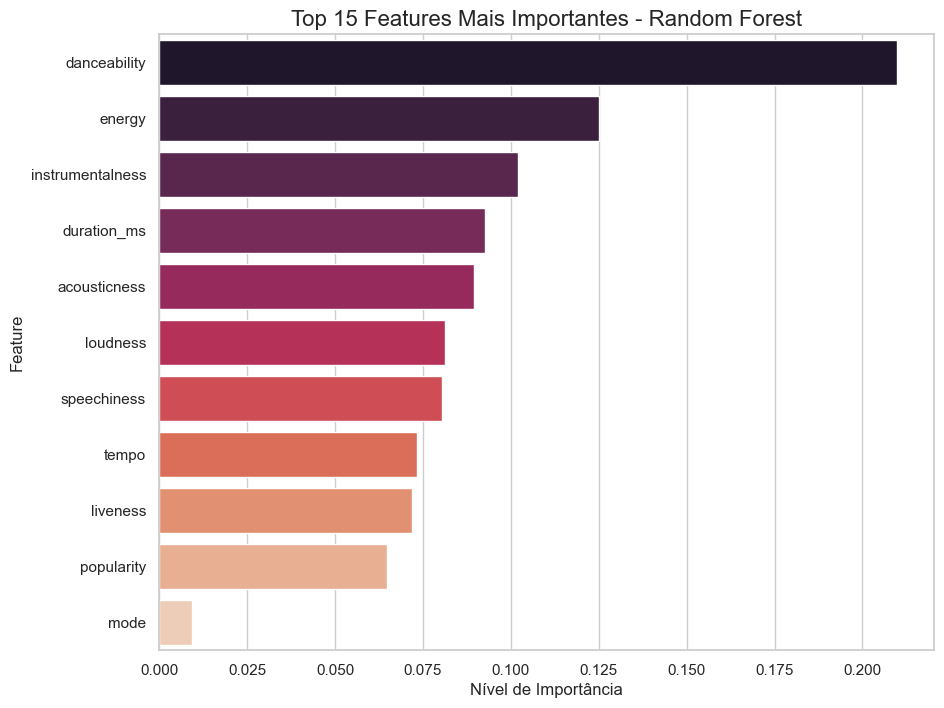

In [ ]:
# identifica o melhor modelo pela tabela de resultados
best_model_name = df_results.iloc[0]['Modelo']
final_model = analysis_data[best_model_name]['model']
y_pred_final = analysis_data[best_model_name]['y_pred']

print("\n" + "="*50)
print(f"--- ANÁLISE DETALHADA DO MODELO CAMPEÃO: {best_model_name} ---")
print("="*50)

print("\n>>> Relatório de Classificação:\n")
print(classification_report(y_test, y_pred_final, target_names=['Humor Baixo (0)', 'Humor Alto (1)']))

print("\n>>> Matriz de Confusão:\n")
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Baixo', 'Alto'],
            yticklabels=['Baixo', 'Alto'])
plt.title(f'Matriz de Confusão - {best_model_name}', fontsize=16)
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

# esta análise funciona melhor para modelos baseados em árvore (Random Forest, Gradient Boosting)
if hasattr(final_model, 'feature_importances_'):
    print("\n>>> Importância das Features:\n")
    importances = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,  # X é o seu dataframe de features ANTES de escalar
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("As 15 features mais importantes para o modelo:")
    display(feature_importance_df.head(15))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='rocket')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}', fontsize=16)
    plt.xlabel('Nível de Importância')
    plt.ylabel('Feature')
    plt.show()

